In [29]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [30]:
df = pd.read_csv('movies_metadata.csv')
df.head().transpose()

,0,1,2,3,4
adult,False,False,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"{'id': 96871, 'name': 'Father of the Bride Col..."
budget,30000000,65000000,0,16000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...


In [31]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [32]:
df.shape

(45466, 24)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

In [34]:
df = df.drop(['imdb_id'], axis=1)

In [35]:
df[df['original_title'] != df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


In [36]:
df = df.drop('original_title', axis=1)

In [37]:
df[df['revenue'] == 0].shape

(38052, 22)

In [38]:
df['revenue'] = df['revenue'].replace(0, np.nan)

In [39]:
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape

(36576, 22)

In [40]:
df['return'] = df['revenue'] / df['budget']
df[df['return'].isnull()].shape

(40085, 23)

In [41]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [42]:
df = df.drop('adult', axis=1)

In [43]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
df['poster_path'] = "<img src='" + base_poster_url + df['poster_path'] + "' style='height:100px;'>"

In [44]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [46]:
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [47]:
s = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [48]:
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

In [49]:
fran_pivot = df_fran.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

In [50]:
fran_pivot.sort_values('sum', ascending=False).head(20)

,belongs_to_collection,count,mean,sum
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
646,James Bond Collection,26,2.733450e+08,7.106970e+09
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09
1550,Transformers Collection,5,8.732202e+08,4.366101e+09
325,Despicable Me Collection,4,9.227676e+08,3.691070e+09
1491,The Twilight Collection,5,6.684215e+08,3.342107e+09
610,Ice Age Collection,5,6.433417e+08,3.216709e+09
666,Jurassic Park Collection,4,7.578710e+08,3.031484e+09


In [51]:
fran_pivot.sort_values('mean', ascending=False).head(20)

,belongs_to_collection,count,mean,sum
112,Avatar Collection,1,2.787965e+09,2.787965e+09
1245,The Avengers Collection,2,1.462481e+09,2.924962e+09
479,Frozen Collection,1,1.274219e+09,1.274219e+09
446,Finding Nemo Collection,2,9.844532e+08,1.968906e+09
1352,The Hobbit Collection,3,9.785078e+08,2.935523e+09
1388,The Lord of the Rings Collection,3,9.721816e+08,2.916545e+09
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
325,Despicable Me Collection,4,9.227676e+08,3.691070e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09


In [52]:
fran_pivot.sort_values('count', ascending=False).head(20)

,belongs_to_collection,count,mean,sum
646,James Bond Collection,26,2.733450e+08,7.106970e+09
473,Friday the 13th Collection,12,3.874155e+07,4.648985e+08
976,Pokémon Collection,11,6.348189e+07,6.983008e+08
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
540,Halloween Collection,8,3.089601e+07,2.471681e+08
29,A Nightmare on Elm Street Collection,8,4.544894e+07,3.635916e+08
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
1432,The Pink Panther (Original) Collection,8,2.055978e+07,1.644782e+08
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
977,Police Academy Collection,7,4.352046e+07,3.046432e+08


In [53]:
new_pivot = df.pivot_table(index='title', values='revenue', aggfunc={'revenue': [ 'sum']}).reset_index()

In [54]:
new_pivot.sort_values('sum', ascending=False).head(20)

,title,sum
3398,Avatar,2.787965e+09
28846,Star Wars: The Force Awakens,2.068224e+09
38665,Titanic,1.849939e+09
4093,Beauty and the Beast,1.689337e+09
2032,Alice in Wonderland,1.597491e+09
30694,The Avengers,1.568143e+09
16855,Jurassic World,1.513529e+09
12321,Furious 7,1.506249e+09
3405,Avengers: Age of Ultron,1.405404e+09
13789,Harry Potter and the Deathly Hallows: Part 2,1.342000e+09


In [55]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [56]:
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

In [57]:
com_df = df.drop('production_companies', axis=1).join(s)

In [58]:
com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

In [59]:
com_pivot.sort_values('Total', ascending=False).head(20)

,Total,Average,Number
Warner Bros.,6.352519e+10,1.293792e+08,491
Universal Pictures,5.525919e+10,1.193503e+08,463
Paramount Pictures,4.880819e+10,1.235650e+08,395
Twentieth Century Fox Film Corporation,4.768775e+10,1.398468e+08,341
Walt Disney Pictures,4.083727e+10,2.778046e+08,147
Columbia Pictures,3.227974e+10,1.367785e+08,236
New Line Cinema,2.217339e+10,1.119868e+08,198
Amblin Entertainment,1.734372e+10,2.550547e+08,68
DreamWorks SKG,1.547575e+10,1.984071e+08,78
Dune Entertainment,1.500379e+10,2.419966e+08,62


In [60]:
com_pivot[com_pivot['Number'] >= 15].sort_values('Average', ascending=False).head(20)

,Total,Average,Number
Pixar Animation Studios,1.118853e+10,6.215852e+08,18
Marvel Studios,1.169964e+10,6.157703e+08,19
Revolution Sun Studios,8.120339e+09,5.413559e+08,15
Lucasfilm,9.898421e+09,4.499282e+08,22
DreamWorks Animation,1.370752e+10,4.031622e+08,34
DC Entertainment,6.212609e+09,3.882880e+08,16
Dentsu,6.853205e+09,3.807336e+08,18
Jerry Bruckheimer Films,8.957441e+09,3.732267e+08,24
Marvel Enterprises,6.538067e+09,3.441088e+08,19
Legendary Pictures,1.346866e+10,3.367166e+08,40


In [61]:
df['original_language'].drop_duplicates().shape[0]

93

In [62]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [63]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [64]:
df['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

In [65]:
df[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(20)

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014
26564,Deadpool,187.860492,2016
26566,Guardians of the Galaxy Vol. 2,185.330992,2017
14551,Avatar,185.070892,2009
24351,John Wick,183.870374,2014
23675,Gone Girl,154.801009,2014


In [66]:
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(20)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


In [67]:
df['vote_average'] = df['vote_average'].replace(0, np.nan)
df['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

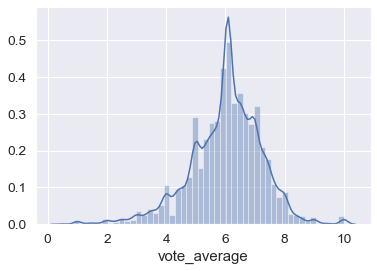

In [68]:
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

In [69]:
df[df['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(20)

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994
834,The Godfather,8.5,6024.0,1972
2211,Life Is Beautiful,8.3,3643.0,1997
5481,Spirited Away,8.3,3968.0,2001
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975
1176,Psycho,8.3,2405.0,1960
2843,Fight Club,8.3,9678.0,1999
1178,The Godfather: Part II,8.3,3418.0,1974
12481,The Dark Knight,8.3,12269.0,2008
292,Pulp Fiction,8.3,8670.0,1994


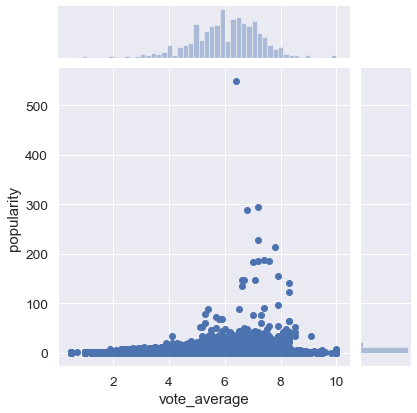

In [70]:
sns.jointplot(x='vote_average', y='popularity', data=df)

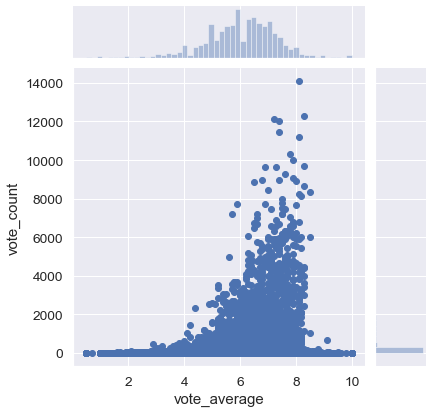

In [71]:
sns.jointplot(x='vote_average', y='vote_count', data=df)

In [72]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [73]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [74]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [75]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

In [76]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index


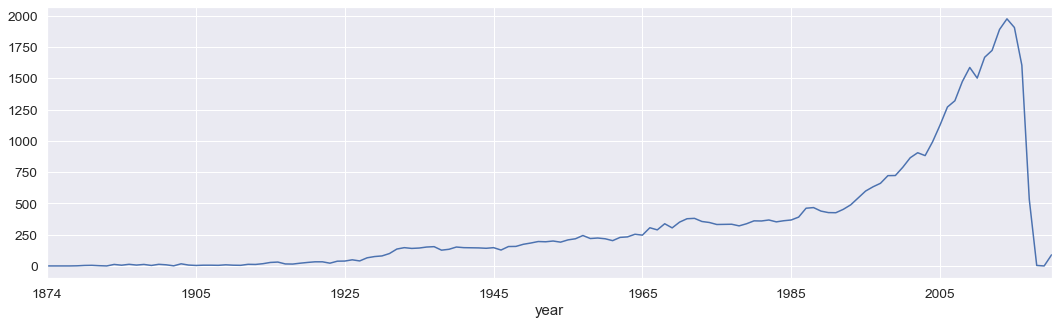

In [77]:
year_count = df.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
year_count.plot()

In [78]:
df[df['year'] != 'NaT'][['title', 'year']].sort_values('year').head(10)

,title,year
34940,Passage of Venus,1874
34937,Sallie Gardner at a Gallop,1878
41602,Buffalo Running,1883
34933,Man Walking Around a Corner,1887
34934,Accordion Player,1888
34938,Traffic Crossing Leeds Bridge,1888
34936,"Monkeyshines, No. 2",1890
34939,London's Trafalgar Square,1890
34935,"Monkeyshines, No. 1",1890
41194,Mosquinha,1890


In [79]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [80]:
df_21 = df.copy()
df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year'] >=2000]
hmap_21 = pd.pivot_table(data=df_21, index='month', columns='year', aggfunc='count', values='title')
hmap_21 = hmap_21.fillna(0)

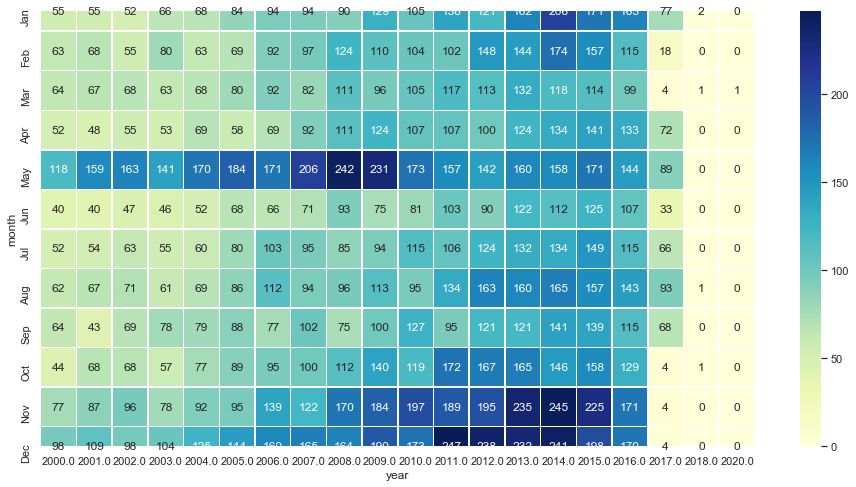

In [81]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order,cmap="YlGnBu")

In [82]:
sns.set(font_scale=1.25)

In [83]:
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)

In [84]:
df['runtime'] = df['runtime'].astype('float')

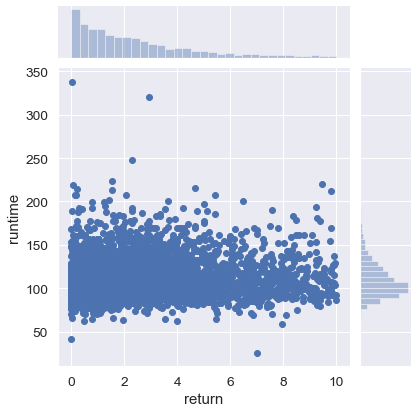

In [85]:
df_mat = df[(df['return'].notnull()) & (df['runtime'] > 0) & (df['return'] < 10)]
sns.jointplot('return', 'runtime', data=df_mat)
plt.show()

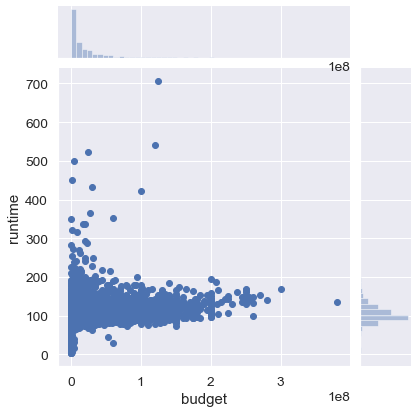

In [86]:
df_mat = df[(df['budget'].notnull()) & (df['runtime'] > 0)]
sns.jointplot('budget', 'runtime', data=df_mat)
plt.show()

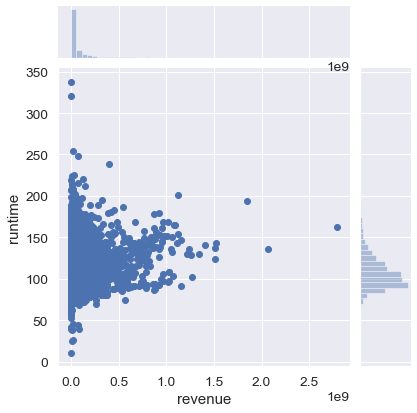

In [87]:
df_mat = df[(df['revenue'].notnull()) & (df['runtime'] > 0)]
sns.jointplot('revenue', 'runtime', data=df_mat)
plt.show()

In [88]:

year_runtime = df[df['year'] != 'NaT'].groupby('year')['runtime'].mean()


In [173]:
df[df['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False).head(20)

,title,budget,revenue,return,year
17193,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011.0
11872,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007.0
26643,Avengers: Age of Ultron,280000000.0,1.405404e+09,5.019299,2015.0
11106,Superman Returns,270000000.0,3.910812e+08,1.448449,2006.0
44915,Transformers: The Last Knight,260000000.0,6.049421e+08,2.326701,2017.0
16197,Tangled,260000000.0,5.917949e+08,2.276134,2010.0
18757,John Carter,260000000.0,2.841391e+08,1.092843,2012.0
11825,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007.0
21248,The Lone Ranger,255000000.0,8.928991e+07,0.350157,2013.0
43330,The Fate of the Furious,250000000.0,1.238765e+09,4.955059,2017.0


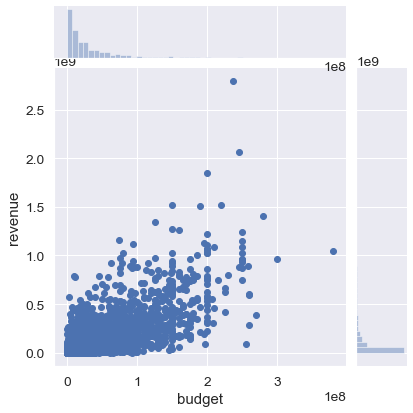

In [90]:
sns.jointplot(x='budget',y='revenue',data=df[df['return'].notnull()])

In [91]:
df['year'] = df['year'].replace('NaT', np.nan)

In [92]:
df['year'] = df['year'].apply(clean_numeric)

In [93]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [94]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [95]:
gen_df = df.drop('genres', axis=1).join(s)

In [96]:
gen_df['genre'].value_counts().shape[0]

32

In [97]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Adventure', 'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

In [98]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

<Figure size 1296x576 with 0 Axes>

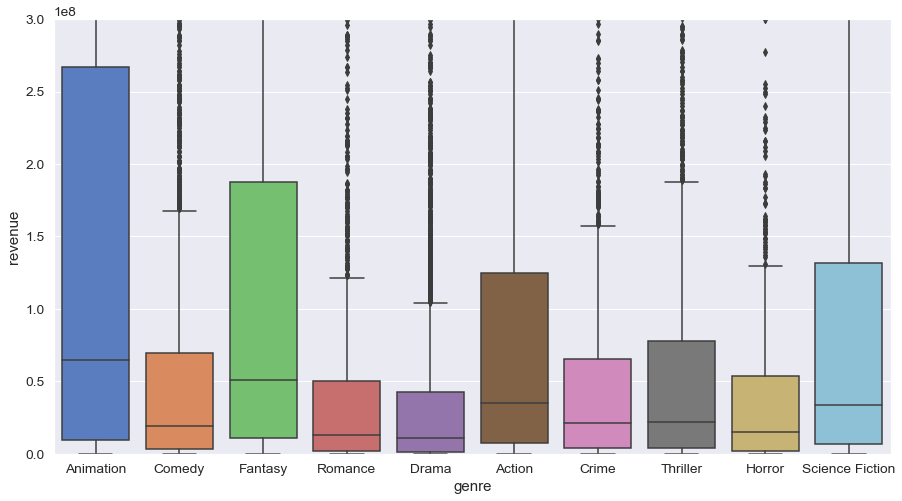

In [99]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='revenue', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 3e8])
plt.show()

<Figure size 1296x576 with 0 Axes>

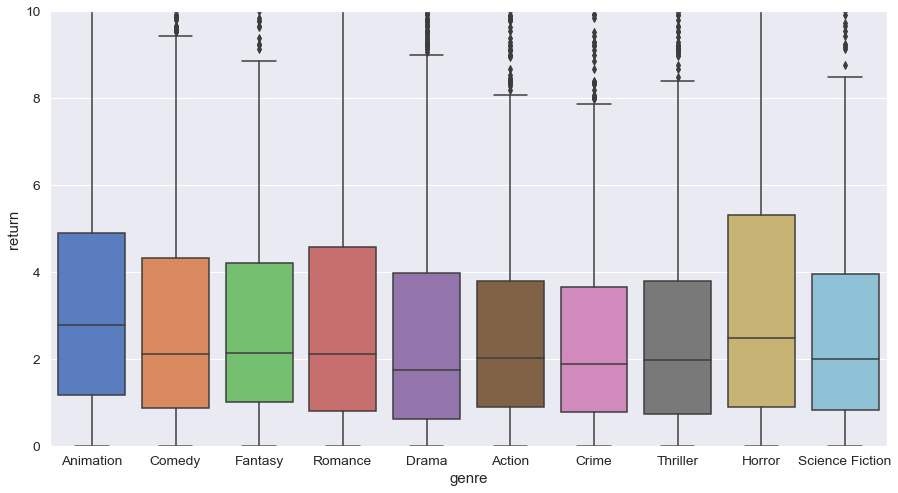

In [100]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='return', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 10])
plt.show()

In [101]:
credits_df = pd.read_csv('credits.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [102]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [103]:
df['id'] = df['id'].apply(convert_int)

In [104]:
df[df['id'].isnull()]

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,status,tagline,title,video,vote_average,vote_count,return,year,day,month
19730,0.065736,NaN,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,104.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Midni...,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,1.931659,NaN,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,68.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Mardo...,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,2.185485,NaN,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,82.0,Released,NaN,<img src='http://image.tmdb.org/t/p/w185/Avala...,[],...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
df = df.drop([19730, 29503, 35587])

In [106]:
df['id'] = df['id'].astype('int')

In [107]:
df = df.merge(credits_df, on='id')
df.shape

(45538, 27)

In [108]:
df['cast'] = df['cast'].apply(ast.literal_eval)
df['crew'] = df['crew'].apply(ast.literal_eval)

In [109]:
df['cast_size'] = df['cast'].apply(lambda x: len(x))
df['crew_size'] = df['crew'].apply(lambda x: len(x))

In [110]:
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [111]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [112]:
df['director'] = df['crew'].apply(get_director)

In [113]:
s = df.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'actor'
cast_df = df.drop('cast', axis=1).join(s)

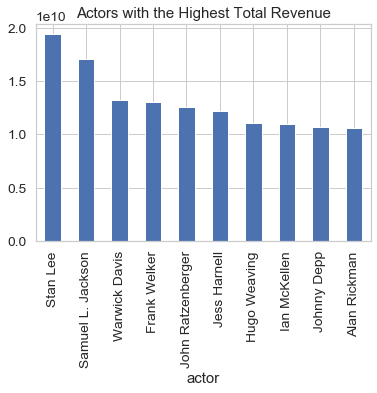

In [114]:
sns.set_style('whitegrid')
plt.title('Actors with the Highest Total Revenue')
cast_df.groupby('actor')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

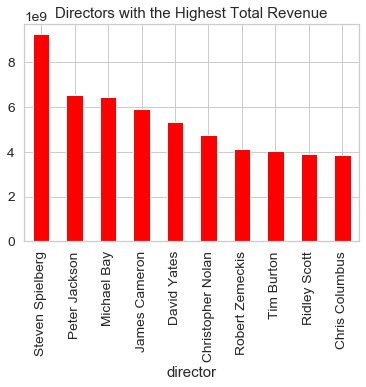

In [115]:
plt.title('Directors with the Highest Total Revenue')
df.groupby('director')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar', colormap='autumn')
plt.show()

In [116]:
actor_list = cast_df.groupby('actor')['revenue'].count().sort_values(ascending=False)
actor_list = list(actor_list[actor_list >= 5].index)
director_list = df.groupby('director')['revenue'].count().sort_values(ascending=False)
director_list = list(director_list[director_list >= 5].index)

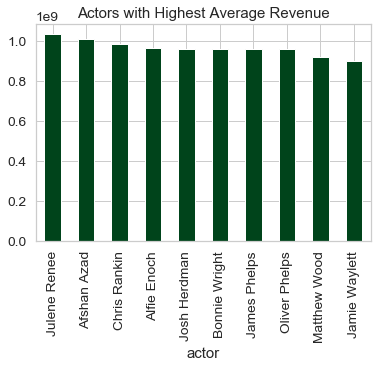

In [117]:
plt.title("Actors with Highest Average Revenue")
cast_df[cast_df['actor'].isin(actor_list)].groupby('actor')['revenue'].mean().sort_values(ascending=False).head(10).plot(kind='bar', colormap='Greens_r')
plt.show()

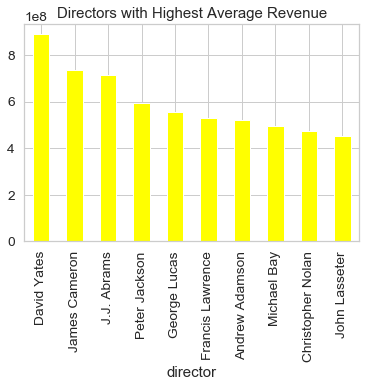

In [118]:
plt.title("Directors with Highest Average Revenue")
df[df['director'].isin(director_list)].groupby('director')['revenue'].mean().sort_values(ascending=False).head(10).plot(kind='bar', colormap='autumn_r')
plt.show()

## Regression

In [119]:
rgf = df[df['return'].notnull()]
rgf.shape

(5393, 30)

In [120]:
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [121]:
rgf = rgf.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'video', 'return', 'crew'], axis=1)

In [122]:
s = rgf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_rgf = rgf.drop('genres', axis=1).join(s)
genres_train = gen_rgf['genre'].drop_duplicates()

In [123]:
def feature_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if x == np.nan else 1)
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df['homepage'] = df['homepage'].apply(lambda x: 0 if x == np.nan else 1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director'], axis=1)
    df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    return df

In [124]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']

In [125]:
X = feature_engineering(X)

In [126]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [127]:
X.shape

(5393, 38)

In [128]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.7774976905752037

In [172]:
from sklearn.tree import DecisionTreeRegressor

regr_2 = DecisionTreeRegressor(max_depth=5)
regr_2.fit(train_X, train_y)
regr_2.score(test_X, test_y)

0.20125304046170167

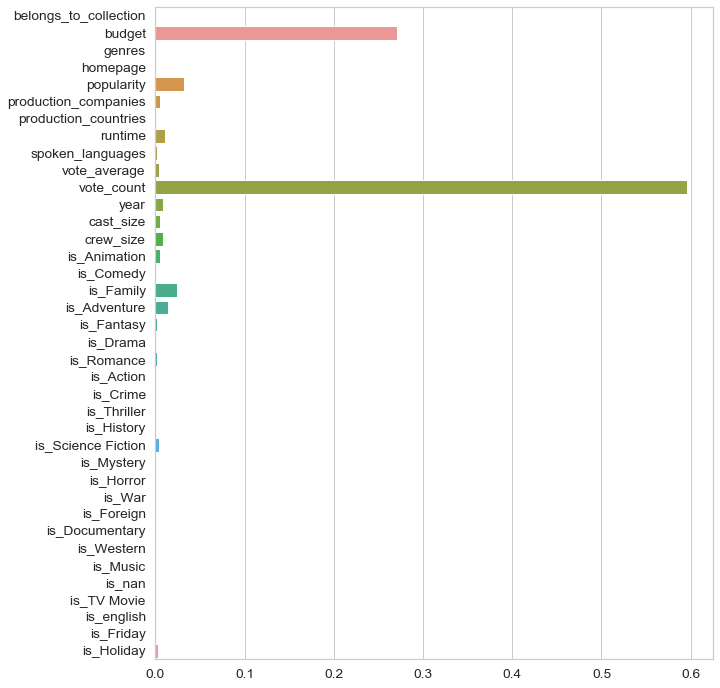

In [130]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

## Classification

In [131]:
cls = df[df['return'].notnull()]
cls.shape

(5393, 30)

In [132]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [133]:
cls = cls.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'revenue'], axis=1)

In [134]:
cls['return'] = cls['return'].apply(lambda x: 1 if x >=1 else 0)

In [135]:
cls['return'].value_counts()

1    3784
0    1609
Name: return, dtype: int64

In [136]:
cls['belongs_to_collection'] = cls['belongs_to_collection'].fillna('').apply(lambda x: 0 if x == '' else 1)

In [139]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

In [140]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'spoken_languages', 'title', 'video',
       'vote_average', 'vote_count', 'return', 'year', 'day', 'month', 'cast',
       'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [141]:
def classification_engineering(df):
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df = df.drop('homepage', axis=1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director'], axis=1)
    #df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    df = df.drop('crew', axis=1)
    return df
    

In [142]:
cls = classification_engineering(cls)

In [143]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'popularity',
       'production_companies', 'production_countries', 'runtime',
       'spoken_languages', 'video', 'vote_average', 'vote_count', 'return',
       'year', 'cast_size', 'crew_size', 'is_Animation', 'is_Comedy',
       'is_Family', 'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance',
       'is_Action', 'is_Crime', 'is_Thriller', 'is_History',
       'is_Science Fiction', 'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign',
       'is_Documentary', 'is_Western', 'is_Music', 'is_nan', 'is_TV Movie',
       'is_english', 'is_Friday', 'is_Holiday'],
      dtype='object')

In [144]:
X, y = cls.drop('return', axis=1), cls['return']

In [145]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [146]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

0.8005930318754633

In [147]:
from sklearn import svm
clf2 = svm.SVC()
clf2.fit(train_X, train_y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [148]:
clf2.score(test_X, test_y)

0.7034840622683469

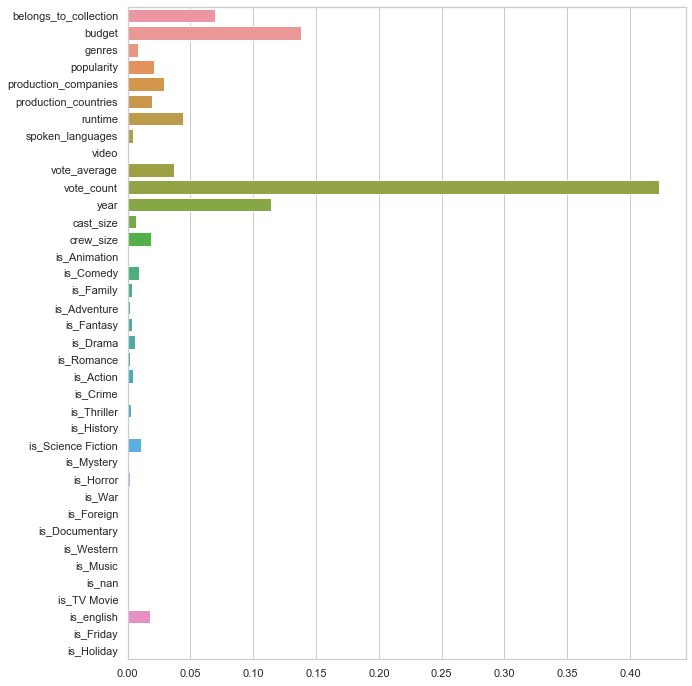

In [150]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)